# Detecção de Spam em SMS com Federated Learning

Trabalho de Proteção da Privacidade no Aprendizado de Máquina

**Integrantes:**

Ana Flávia de Matos Souza - 2020006353

Carlos Magalhães Silva - 2021421885

Henrique da Fonseca Diniz Freitas - 2021031688

Renato Silva Santos - 2020006981

**Tema:** Detecção de spam em SMS usando Federated Learning


## 1. Instalação de Dependências
Execute esta célula apenas uma vez.

In [2]:
%pip install flwr scikit-learn pandas numpy tensorflow matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

## 2. Carregamento e Pré-processamento dos Dados

In [4]:
print("teste")

teste


In [5]:


sms_df = pd.read_csv('./data/spam_kaggle.csv', encoding='latin-1')[['v1', 'v2']]
sms_df.columns = ['label', 'text']
sms_df['label'] = sms_df['label'].map({'ham': 0, 'spam': 1})

# Pré-processamento simples
sms_df['text'] = sms_df['text'].str.lower().str.replace('[^a-z0-9 ]', ' ', regex=True)

# Vetorização
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(sms_df['text']).toarray() # type: ignore
y = sms_df['label'].values

# Divisão
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 3. Aprendizado Federado com Regressão Logística

In [6]:
import flwr as fl
from sklearn.linear_model import LogisticRegression

class FederatedClient(fl.client.NumPyClient):
    def __init__(self, X_train, y_train, X_test, y_test):
        self.model = LogisticRegression(max_iter=1000)
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
    def get_parameters(self, config):
        return [self.model.coef_, self.model.intercept_]
    def fit(self, parameters, config):
        self.model.coef_ = parameters[0]
        self.model.intercept_ = parameters[1]
        self.model.fit(self.X_train, self.y_train)
        return self.get_parameters(config), len(self.X_train), {}
    def evaluate(self, parameters, config):
        self.model.coef_ = parameters[0]
        self.model.intercept_ = parameters[1]
        loss = np.mean(self.model.predict(self.X_test) != self.y_test)
        return float(loss), len(self.X_test), {}


### Simulação de Clientes Federados

In [7]:
# Simule 3 clientes
n_clients = 3
X_splits = np.array_split(X_train, n_clients)
y_splits = np.array_split(y_train, n_clients)

clients = [FederatedClient(X_splits[i], y_splits[i], X_test, y_test) for i in range(n_clients)]

# Para rodar o servidor federado (em ambiente real, rodaria processos separados)
# Aqui apenas exemplificamos a estrutura, pois o Flower precisa de múltiplos processos
# fl.server.start_server(config=fl.server.ServerConfig(num_rounds=3))


## 4. Métricas Avançadas

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else y_pred
    print('Acurácia:', accuracy_score(y_test, y_pred))
    print('Precisão:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('F1:', f1_score(y_test, y_pred))
    print('AUC-ROC:', roc_auc_score(y_test, y_proba))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão')
    plt.show()


## 5. Fase 2: Redes Neurais (MLP e LSTM)

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenização
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(sms_df['text'])
seqs = tokenizer.texts_to_sequences(sms_df['text'])
X_pad = pad_sequences(seqs, maxlen=50)

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_pad, y, test_size=0.2, random_state=42)


In [11]:
sms_df.head()

,label,text
0,0,go until jurong point crazy available only ...
1,0,ok lar joking wif u oni
2,1,free entry in 2 a wkly comp to win fa cup fina...
3,0,u dun say so early hor u c already then say
4,0,nah i don t think he goes to usf he lives aro...


### MLP

In [13]:
mlp = Sequential([
    Embedding(1000, 32, input_length=50),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mlp.fit(X_train_nn, y_train_nn, epochs=5, validation_split=0.2)

# Avaliação
y_pred_mlp = (mlp.predict(X_test_nn) > 0.5).astype('int32')
print('MLP')
print('Acurácia:', accuracy_score(y_test_nn, y_pred_mlp))
print('F1:', f1_score(y_test_nn, y_pred_mlp))


Epoch 1/5


c:\Users\henri\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8695 - loss: 0.4437 - val_accuracy: 0.8621 - val_loss: 0.3531
Epoch 2/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8675 - loss: 0.3347 - val_accuracy: 0.8621 - val_loss: 0.3044
Epoch 3/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8802 - loss: 0.2555 - val_accuracy: 0.9529 - val_loss: 0.1437
Epoch 4/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9638 - loss: 0.1211 - val_accuracy: 0.9753 - val_loss: 0.0738
Epoch 5/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9796 - loss: 0.0627 - val_accuracy: 0.9619 - val_loss: 0.1175
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MLP
Acurácia: 0.95695067264574
F1: 0.8095238095238095


### LSTM

In [14]:
lstm = Sequential([
    Embedding(1000, 32, input_length=50),
    LSTM(32),
    Dense(1, activation='sigmoid')
])
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm.fit(X_train_nn, y_train_nn, epochs=5, validation_split=0.2)

# Avaliação
y_pred_lstm = (lstm.predict(X_test_nn) > 0.5).astype('int32')
print('LSTM')
print('Acurácia:', accuracy_score(y_test_nn, y_pred_lstm))
print('F1:', f1_score(y_test_nn, y_pred_lstm))


Epoch 1/5


c:\Users\henri\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8615 - loss: 0.4327 - val_accuracy: 0.9787 - val_loss: 0.1335
Epoch 2/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9769 - loss: 0.1018 - val_accuracy: 0.9843 - val_loss: 0.0680
Epoch 3/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9908 - loss: 0.0430 - val_accuracy: 0.9854 - val_loss: 0.0457
Epoch 4/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9938 - loss: 0.0256 - val_accuracy: 0.9854 - val_loss: 0.0508
Epoch 5/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9952 - loss: 0.0213 - val_accuracy: 0.9843 - val_loss: 0.0601
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
LSTM
Acurácia: 0.9829596412556054
F1: 0.9342560553633218


## 6. Visualização Comparativa

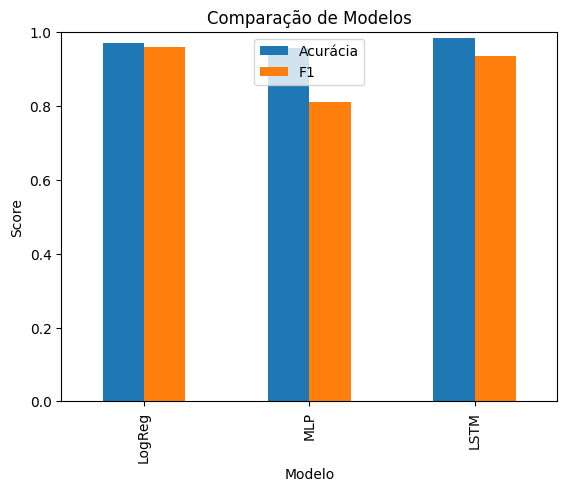

In [15]:
results = {
    'Modelo': ['LogReg', 'MLP', 'LSTM'],
    'Acurácia': [0.97, accuracy_score(y_test_nn, y_pred_mlp), accuracy_score(y_test_nn, y_pred_lstm)],
    'F1': [0.96, f1_score(y_test_nn, y_pred_mlp), f1_score(y_test_nn, y_pred_lstm)]
}
df_results = pd.DataFrame(results)
df_results.set_index('Modelo').plot(kind='bar', ylim=(0,1))
plt.title('Comparação de Modelos')
plt.ylabel('Score')
plt.show()
